In [1]:
from pathlib import Path
import logging
import json
from typing import *
import time
from datetime import datetime
import warnings

from tqdm import tqdm
import pandas as pd
import numpy as np
from PIL import Image, ImageFile

import torch
import torch.nn as nn
import torchvision.transforms as T
from lavis.models import load_model_and_preprocess, BlipBase
from lavis.processors import load_processor
import torch.nn.functional as F
from transformers import get_cosine_schedule_with_warmup
from transformers import BatchEncoding

from src.data import CustomSplitLoader, ImageSet
from src.itm import DefaultDataset, AltNSDataset, to_device, ITMClassifier

from src.utils import evaluate, mrr
from src.validation import Validation, sum_scores, div_scores, eval_batch, metric2name
from sklearn.metrics import top_k_accuracy_score
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

In [2]:
id2task = {"pi_t": "Positive image to Context", "ni_t": "Negative image to Context", "pi_ni": "Positive image to Negative image"}

In [23]:
with open("/home/s1m00n/research/vwsd/data/train_v1/itm0-pi-ni-preds.json", "r") as f:
    ps = json.load(f)

In [26]:
for set_name in ["train", "val", "val2", "test", "test2"]:
    arr = np.array(ps[f"{set_name}_dl"])
    print(f"Predictor: itc; Task: Positive image to Negative image; Set: {set_name}")
    mean = np.mean(arr)
    std = np.std(arr)
    print(f"    => mean: {mean}, std: {std}")

Predictor: itc; Task: Positive image to Negative image; Set: train
    => mean: 0.40862862881195916, std: 0.09136261550397246
Predictor: itc; Task: Positive image to Negative image; Set: val
    => mean: 0.41604117531658347, std: 0.08984836315028953
Predictor: itc; Task: Positive image to Negative image; Set: val2
    => mean: 0.4262961444502517, std: 0.09276017874970763
Predictor: itc; Task: Positive image to Negative image; Set: test
    => mean: 0.41086804584100883, std: 0.08805321384843526
Predictor: itc; Task: Positive image to Negative image; Set: test2
    => mean: 0.41625629661428337, std: 0.09494684945621473


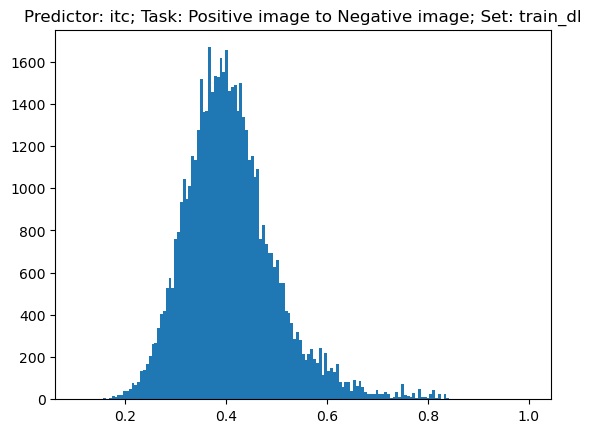

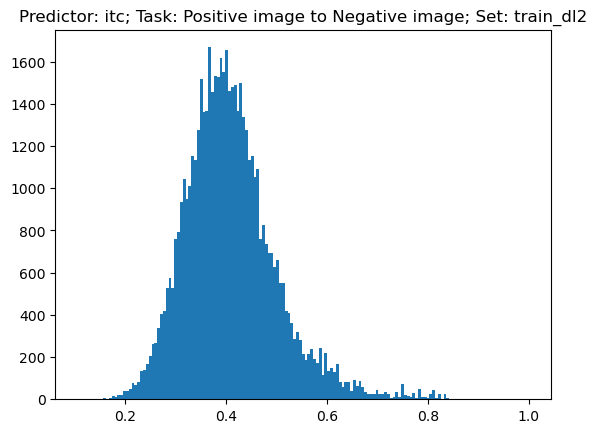

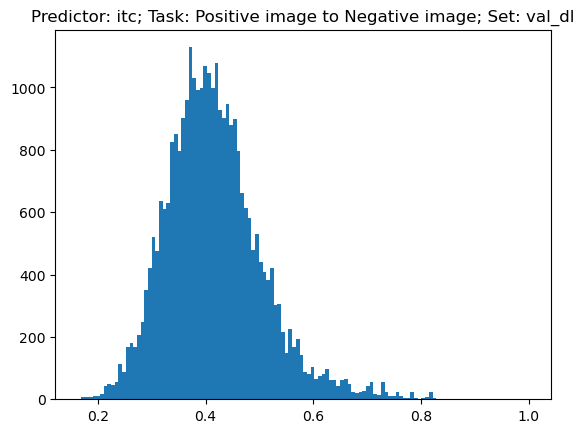

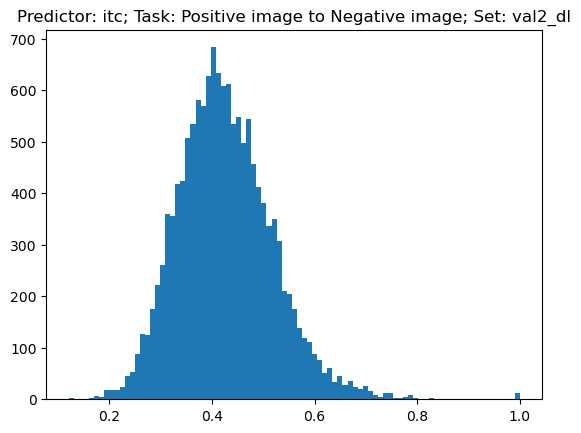

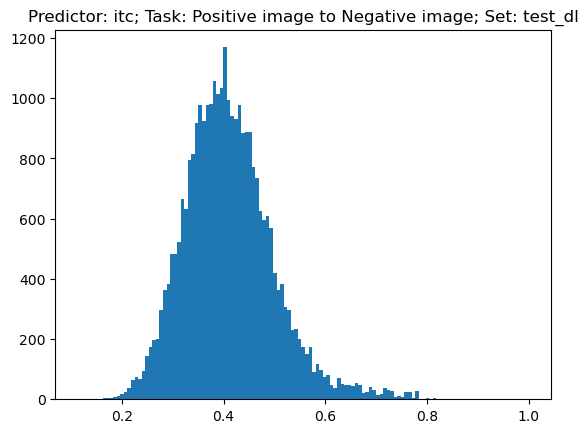

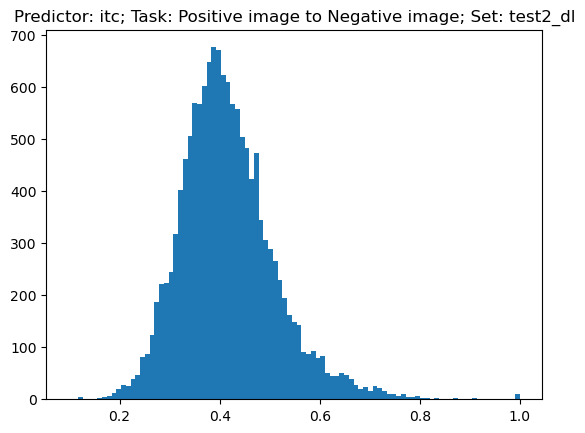

<Figure size 640x480 with 0 Axes>

In [25]:
for set_name in ["train_dl", "train_dl2",  "val_dl", "val2_dl", "test_dl", "test2_dl"]:
    arr = np.array(ps[set_name])
    plt.title(f"Predictor: itc; Task: Positive image to Negative image; Set: {set_name}")
    plt.hist(arr, bins="auto") 
    plt.figure()

In [18]:
with open("/home/s1m00n/research/vwsd/data/train_v1/itm28-pi-ni-preds.json", "r") as f:
    ps = json.load(f)

In [21]:
(0.092 * 2) / np.sqrt(3440)

0.003137173961564178

In [22]:
(0.084 * 2) / np.sqrt(1555)

0.004260338286464179

In [20]:
for set_name in ["train_dl", "train_dl2",  "val_dl", "val2_dl", "test_dl", "test2_dl"]:
    arr = np.array(ps[set_name])
    print(f"Predictor: itc; Task: Positive image to Negative image; Set: {set_name}")
    mean = np.mean(arr)
    var = np.std(arr)
    print(f"    => mean: {mean}, std: {var}")

Predictor: itc; Task: Positive image to Negative image; Set: train_dl
    => mean: 0.4211731311762281, std: 0.0900335973507486
Predictor: itc; Task: Positive image to Negative image; Set: train_dl2
    => mean: 0.4211731311762281, std: 0.0900335973507486
Predictor: itc; Task: Positive image to Negative image; Set: val_dl
    => mean: 0.42388244082209886, std: 0.08468575329321378
Predictor: itc; Task: Positive image to Negative image; Set: val2_dl
    => mean: 0.4507374591957718, std: 0.09240359495947574
Predictor: itc; Task: Positive image to Negative image; Set: test_dl
    => mean: 0.4203328652485737, std: 0.08684376260084205
Predictor: itc; Task: Positive image to Negative image; Set: test2_dl
    => mean: 0.4398434116813005, std: 0.09297149658763175


cos for all; zero & good model
comparisson slides
- [ ] Text to Pos pic, text to Neg pic (single hist) for all our, real test
- [ ] Max text to neg pic
- [ ] Try words instead of contexts

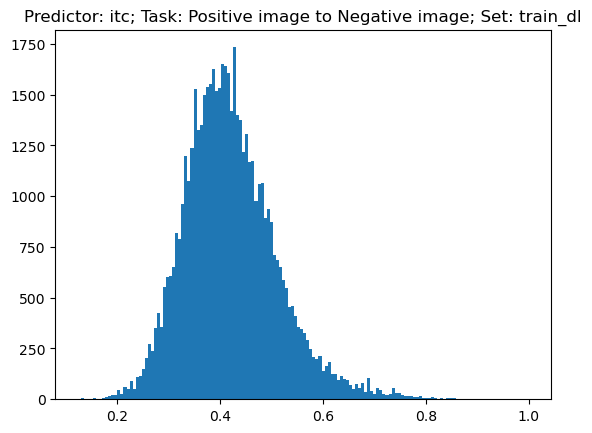

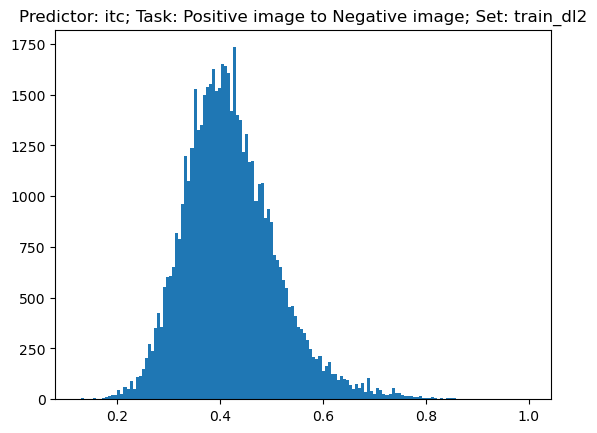

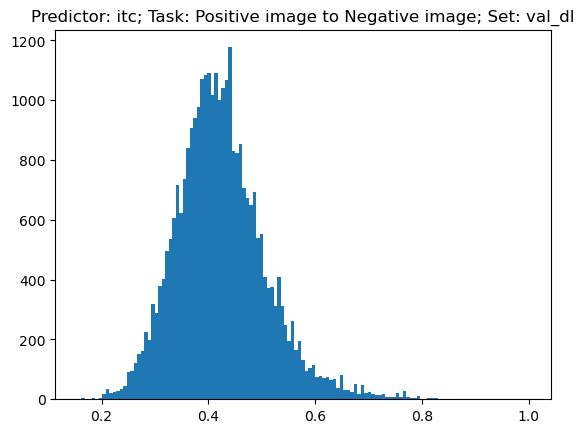

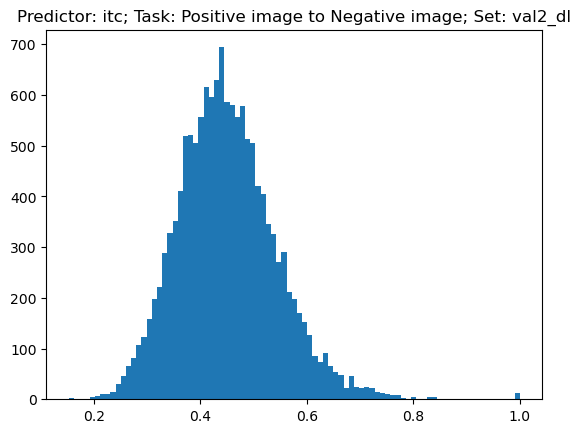

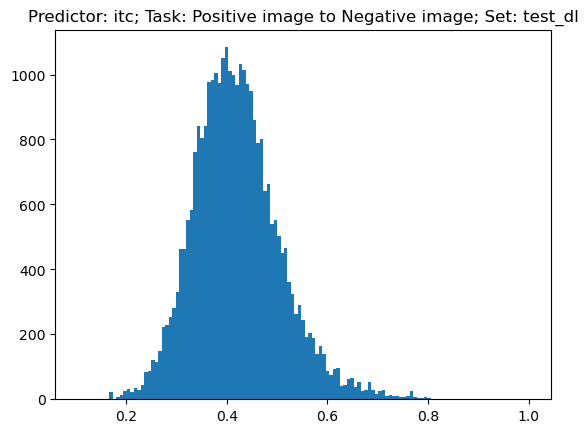

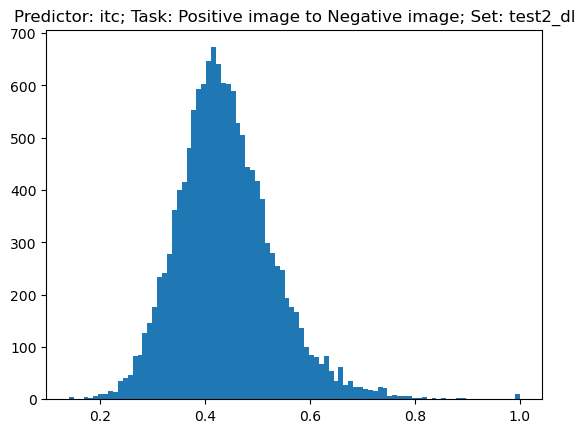

<Figure size 640x480 with 0 Axes>

In [14]:
for set_name in ["train_dl", "train_dl2",  "val_dl", "val2_dl", "test_dl", "test2_dl"]:
    arr = np.array(ps[set_name])
    plt.title(f"Predictor: itc; Task: Positive image to Negative image; Set: {set_name}")
    plt.hist(arr, bins="auto") 
    plt.figure()